# CS 524 Homework 3 (2/18)

## Question 1a

A = $\begin{bmatrix}
-1 & 0 & 0\\
1 & 0 & 0\\
0 & -1 & 0\\
0 & 1 & 0\\
0 & 0 & -1\\
0 & 0 & 1
\end{bmatrix}$
$\quad$x = $\begin{bmatrix}
x\\
y\\
z
\end{bmatrix}$
$\quad$b = $\begin{bmatrix}
1\\
1\\
1\\
1\\
1\\
1
\end{bmatrix}$

## Question 1b

A = $\begin{bmatrix}
1 & 1 & 1\\
1 & -1 & 1\\
1 & 1 & -1\\
1 & -1 & -1\\
-1 & 1 & 1\\
-1 & -1 & 1\\
-1 & 1 & -1\\
-1 & -1 & -1
\end{bmatrix}$
$\quad$x = $\begin{bmatrix}
x\\
y\\
z
\end{bmatrix}$
$\quad$b = $\begin{bmatrix}
1\\
1\\
1\\
1\\
1\\
1\\
1\\
1
\end{bmatrix}$

## Question 2a

This is similar to the Chebyshev Center problem. <br/>
<br/>
The decision variables are:
- y, the center of the sphere/circle
- r, the radius of the sphere/circle

The constriants are the site boundaries:
- y $\le$ 500
- -y $\le$ 0
- -x $\le$ 0
- 3x - y $\le$ 1500
- 2x + 3y $\le$ 2100

The objective function is to maximize the radius, r subject to: <br/>
$a_i^Ty + ||a_i||r \le b_i - 50$ and $r \ge 0$

## Question 2b

In [13]:
using JuMP, Clp, LinearAlgebra

A = [3 -1; 2 3; 0 1; 0 -1; -1 0]
b = [1500; 2100; 500; 0; 0]
    
m_museum = Model(with_optimizer(Clp.Optimizer))

@variable(m_museum, r >= 0) # radius
@variable(m_museum, x[1:2] >= 0) # coordinates of center

for i in 1:size(A,1)
    @constraint(m_museum, A[i,:]'*x + r*norm(A[i,:]) <= b[i]-50)
end

@objective(m_museum, Max, r)
println(m_museum)

optimize!(m_museum)
center = value.(x)
radius = value(r)
println("Our solution is ", termination_status(m_museum))
println("The coordinates of the Chebyshev center are: ", center)
println("The largest possible radius is: ", radius)
println()

Max r
Subject to
 3.1622776601683795 r + 3 x[1] - x[2] <= 1450.0
 3.605551275463989 r + 2 x[1] + 3 x[2] <= 2050.0
 r + x[2] <= 450.0
 r - x[2] <= -50.0
 r - x[1] <= -50.0
 r >= 0.0
 x[1] >= 0.0
 x[2] >= 0.0

Our solution is OPTIMAL
The coordinates of the Chebyshev center are: [250.0, 250.0]
The largest possible radius is: 200.0

Coin0506I Presolve 5 (0) rows, 3 (0) columns and 12 (0) elements
Clp0006I 0  Obj 0 Primal inf 100 (2) Dual inf 0.9999999 (1)
Clp0006I 3  Obj 200
Clp0000I Optimal - objective value 200
Clp0032I Optimal objective 200 - 3 iterations time 0.002


## Question 2c

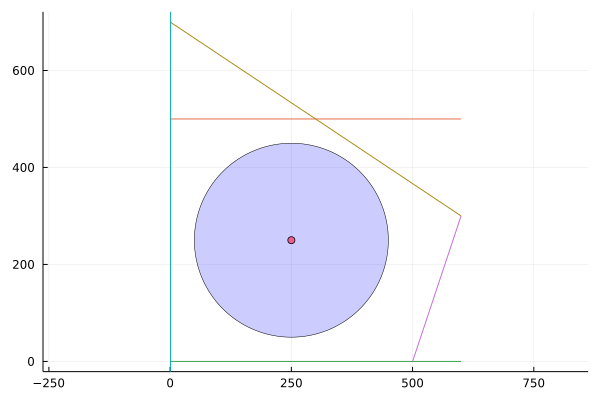

In [58]:
# using Pkg
# Pkg.add("Plots")

using Plots

function circleShape(h, k, r)
    theta = LinRange(0, 2*pi, 500)
    h .+ r*sin.(theta), k .+ r*cos.(theta)
end
plot(circleShape(250,250,200), seriestype = [:shape,], lw = 0.5,
    c = :blue, linecolor = :black,
    legend = false, fillalpha = 0.2, aspect_ratio = 1)

f1(x) = 500
f2(x) = 0
f3(x) = 3x - 1500
f4(x) = -2x/3 + 700
ctr = [250]
plot!(f1, 0, 600)
plot!(f2, 0, 600)
plot!(f3, 500, 600)
plot!(f4, 0, 600)
vline!([1])
scatter!(ctr, [250, 250])

## Question 3a

The decision variables are:
- the name of the employee for that time interval
- the time interval

The constriants are:
- first interval (10am) needs to have two employees, one of which needs to be either Mirjam or Matt
- 3 employees take candidate out for lunch
- all employees meet the candidate
- candidate meets someone in each interval
- candidate does not meet the same person twice

The objective is:
- to find a schedule that shows which employee the candidate meets at each time interval

## Question 3b

In [13]:
# using Pkg
# Pkg.add("NamedArrays")

In [53]:
using JuMP, NamedArrays, Clp, LinearAlgebra

availability =
  [ 1 1 0 0 0 0 0 0 0 0 1 1 1
    1 1 1 0 0 0 0 0 0 1 1 0 0
    0 0 1 1 0 0 0 1 1 0 0 0 0
    0 1 1 0 0 0 0 0 1 1 0 0 0
    0 0 0 1 1 0 1 1 0 1 1 1 1
    0 0 0 1 1 1 1 1 1 1 1 1 0
    0 0 0 0 0 0 1 1 1 0 0 0 0
    0 1 1 0 0 0 0 0 1 1 0 0 0
    0 0 0 1 1 1 1 0 0 0 0 0 0
    0 0 0 0 0 0 0 1 1 0 0 0 0
    0 0 0 0 0 0 1 1 1 0 0 0 0
    1 1 0 0 0 1 1 1 1 0 0 1 1
    1 1 1 0 1 1 0 0 0 0 0 1 1
    0 1 1 1 0 0 0 0 0 0 0 0 0
    0 1 1 0 0 0 0 1 1 1 0 0 0
    1 1 0 0 1 1 0 0 0 0 0 0 0 ]

TIMES = collect(1:13)
NAMES = [:Mirjam,:Matt,:Manuel,:Luca,:Jule,:Michael,:Malte,:Chris,:Spyros,:Florian,:Josep,:Joel,:Tom,:Daniel,:Christian,:Anne ]
TIMESTR = ["10:00","10:20","10:40","11:00","11:20","11:40","lunch","1:00","1:20","1:40","2:00","2:20","2:40"]

# Creating a NamedArray of the availability data
times = NamedArray( availability, (NAMES,TIMES), ("NAME","TIME"))

# With a NamedArray, it is possible to use symbols as indices (although you don't have to use this)
# For example, it is possible to write
# println(times[:Luca,1])
# or
# println(TIMES[13])

A = availability
m_sched = Model(with_optimizer(Clp.Optimizer))
@variable(m_sched, x[NAMES,TIMES] >= 0)

@constraint(m_sched, a[t in TIMES[1:1]], sum(x[n,t] for n in NAMES[1:2]) == 2 ) # 10:00 has to have either Mirjam or Matt
@constraint(m_sched, b[t in TIMES[2:6]], sum(x[n,t] for n in NAMES) == 1 ) # each time interval has 1 employee
@constraint(m_sched, c[t in TIMES[7:7]], sum(x[n,t] for n in NAMES) == 3) # lunch has 3 employees
@constraint(m_sched, d[t in TIMES[8:13]], sum(x[n,t] for n in NAMES) == 1 ) # each interval from 1:00 to 2:40 has 1 employee
@constraint(m_sched, e[n in NAMES], sum(x[n,t] for t in TIMES) <= 1 )

@objective(m_sched, Min, sum( x[n,t]*times[n,t] for n in NAMES, t in TIMES ))

optimize!(m_sched)
println(termination_status(m_sched),"\n")

OPTIMAL

Coin0506I Presolve 28 (-1) rows, 193 (-15) columns and 386 (-16) elements
Clp0006I 0  Obj 2 Primal inf 14.099987 (13)
Clp0006I 31  Obj 2 Primal inf 25.799986 (14)
Clp0006I 62  Obj 2 Primal inf 15.099989 (11)
Clp0006I 78  Obj 2
Clp0000I Optimal - objective value 2
Coin0511I After Postsolve, objective 2, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 2 - 78 iterations time 0.002, Presolve 0.00


## Question 3c

In [52]:
schedule = NamedArray( [ (value.(x[n,t])) for n in NAMES, t in TIMES ], (NAMES, TIMESTR), ("Names", "Time"))
println(schedule,"\n")

16×13 Named Matrix{Float64}
Names ╲ Time │ 10:00  10:20  10:40  11:00  11:20  11:40  lunch   1:00   1:20   1:40   2:00   2:20   2:40
─────────────┼──────────────────────────────────────────────────────────────────────────────────────────
:Mirjam      │   1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
:Matt        │   1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
:Manuel      │   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0
:Luca        │   0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0
:Jule        │   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0
:Michael     │   0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
:Malte       │   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0
:Chris       │   0.0    0.0